In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

import timeit

# Load data

In [2]:
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample=0.005)

In [3]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  30
num_train_unlabled:  270
num_test:  50


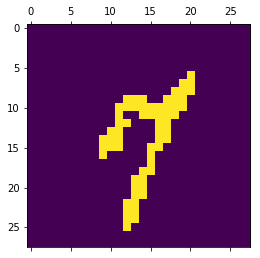

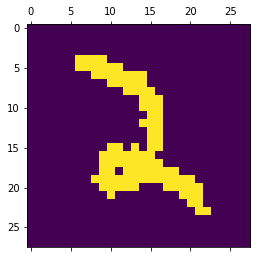

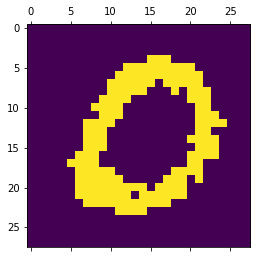

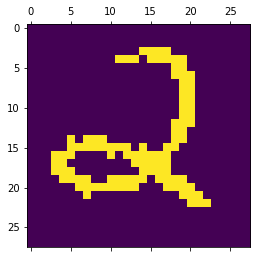

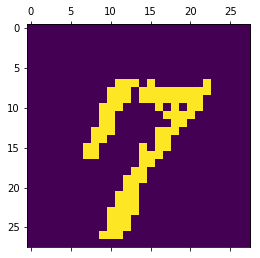

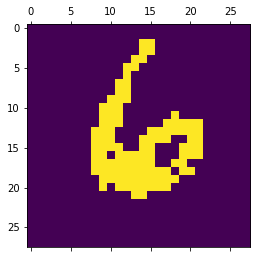

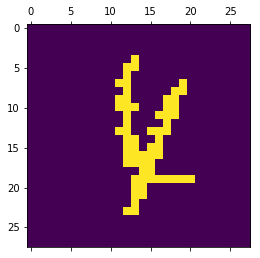

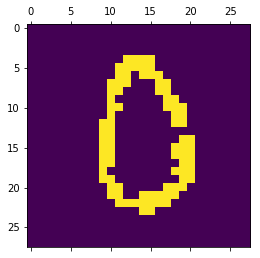

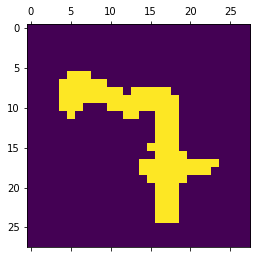

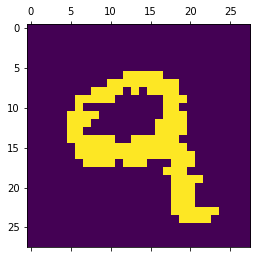

In [4]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())

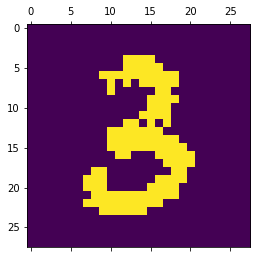

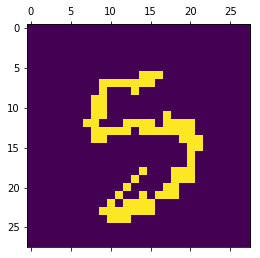

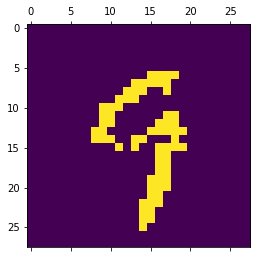

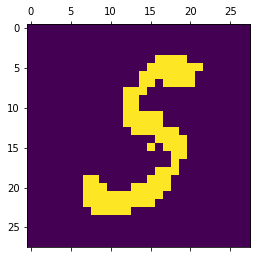

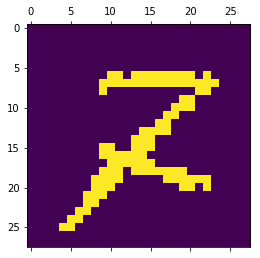

In [5]:
for i in range(5): 
    plt.matshow(test_set[i]['image'].squeeze())

In [6]:
slen = train_set_unlabeled[0]['image'].shape[0]

# Get data loaders

In [7]:
batchsize = 8

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [8]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [9]:
data_unlabeled['image'].shape

torch.Size([8, 28, 28])

# Define VAE

In [10]:
latent_dim = 5
n_classes = 10

In [11]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes, 
                                  use_baseline = True)

In [12]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=10, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=9, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
  (baseline_learner): BaselineLearner(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=1, bias=True)
  )
)>


In [13]:
28 * 28

784

In [14]:
2 * 28 * 28

1568

# Check things run

### check the reinforce sampling

In [15]:
class_weights = torch.Tensor([[0.2, 0.3, 0.06, 0.14, 0.22, 0.08], 
                            [0.1, 0.08, 0.02, 0.2, 0.4, 0.2]])

In [16]:
class_weights

tensor([[ 0.2000,  0.3000,  0.0600,  0.1400,  0.2200,  0.0800],
        [ 0.1000,  0.0800,  0.0200,  0.2000,  0.4000,  0.2000]])

In [17]:
num_reinforced = 3 # so we only sample the three most uncommon weights
z_sample, z_sample_domain, class_weight_sample_conditional, \
    unsampled_z_domain, unsampled_weights = \
        vae._sample_class_weights(class_weights, num_reinforced)

In [18]:
# Lets check the empirical proportions
propn_a2 = 0.06 / (0.06 + 0.08 + 0.14)
propn_a3 = 0.14 / (0.06 + 0.08 + 0.14)
propn_a5 = 0.08 / (0.06 + 0.08 + 0.14)

propn_b1 = 0.08 / (0.08 + 0.02 + 0.10)
propn_b2 = 0.02 / (0.08 + 0.02 + 0.10)
propn_b0 = 0.10 / (0.08 + 0.02 + 0.10)

In [19]:
nsample = 10000
empr_array = np.zeros((nsample, 2))
for i in range(nsample): 
    empr_array[i, :] = vae._sample_class_weights(class_weights, num_reinforced)[0].detach().numpy()

In [20]:
print(np.abs(np.mean(empr_array[:, 0] == 2) - propn_a2))
print(np.abs(np.mean(empr_array[:, 0] == 3) - propn_a3))
print(np.abs(np.mean(empr_array[:, 0] == 5) - propn_a5))

print(np.abs(np.mean(empr_array[:, 1] == 1) - propn_b1))
print(np.abs(np.mean(empr_array[:, 1] == 2) - propn_b2))
print(np.abs(np.mean(empr_array[:, 1] == 0) - propn_b0))

0.003185714285714236
0.0010999999999999899
0.004285714285714282
0.0025000000000000577
0.0059999999999999915
0.0034999999999999476


In [21]:
class_weights = vae.classifier(data_unlabeled['image'])

nsample = 10000
empr_array = torch.zeros((class_weights.shape))
for i in range(nsample): 
    z_sample = vae._sample_class_weights(class_weights, vae.n_classes)[0]
    empr_array += common_utils.get_one_hot_encoding_from_int(z_sample, vae.n_classes) / nsample

In [22]:
print(torch.max(empr_array - class_weights))

tensor(1.00000e-02 *
       1.1981)


In [23]:
num_unlabled = train_loader_unlabeled.sampler.data_source.num_images

In [24]:
vae.get_semisupervised_loss(data_unlabeled['image'], num_unlabeled_total = 10,
                                    labeled_images = data_labeled['image'], labels = data_labeled['label'],
                                    alpha = 1.0, num_reinforced = 10)

(tensor(9808.9248),
 tensor(1.9025e+09),
 tensor(543.0024),
 tensor(545.0762),
 tensor(2.2865))

# Check gradient works 

In [25]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [26]:
vae_params0 = get_vae_params(vae)

In [27]:
assert np.any(np.isnan(vae_params0)) == False

In [28]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [29]:
loss, ps_loss, _, _, _ = vae.get_semisupervised_loss(data_unlabeled['image'], num_unlabled,
                                    labeled_images = data_labeled['image'], labels = data_labeled['label'],
                                    alpha = 1.0, num_reinforced = 10)

In [30]:
ps_loss.backward()
optimizer.step()

In [31]:
vae_params1 = get_vae_params(vae)

In [32]:
assert np.any(np.isnan(vae_params1)) == False

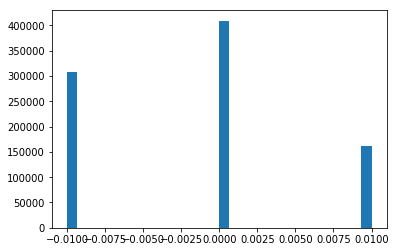

In [33]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [34]:
loss, ps_loss, _, _, _ = vae.get_semisupervised_loss(data_unlabeled['image'], num_unlabled,
                                    labeled_images = data_labeled['image'], labels = data_labeled['label'],
                                    alpha = 1.0, num_reinforced = 10)

In [35]:
assert np.isfinite(loss.detach().numpy())

In [36]:
train_loader_unlabeled.dataset.__len__()

270

In [37]:
data_labeled['image']

tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        ...,

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]

In [38]:
mnist_vae_lib.train_semisupervised_model(vae, train_loader_unlabeled, 
                                         data_labeled['image'], data_labeled['label'], 
                    test_loader, n_epoch = 5, print_every = 2, outfile = './test', num_reinforced = 10)

  * init train recon loss: 490.8710022;
  * init test recon loss: 490.4757385;
  * init train class accuracy: 0.07778;
  * init test class accuracy: 0.14;
[1] unlabeled_loss: 489.2103271  	[2.9 seconds]
[2] unlabeled_loss: 484.8841248  	[2.4 seconds]
  * train recon loss: 481.2154236;
  * test recon loss: 481.6464233;
  * train class accuracy: 0.1074;
  * test class accuracy: 0.16;
[3] unlabeled_loss: 477.4810791  	[2.8 seconds]
[4] unlabeled_loss: 471.0820618  	[2.8 seconds]
  * train recon loss: 466.8633728;
  * test recon loss: 467.2581177;
  * train class accuracy: 0.1111;
  * test class accuracy: 0.14;
[5] unlabeled_loss: 462.6127625  	[2.8 seconds]
writing the encoder parameters to ./test_enc_final

writing the decoder parameters to ./test_dec_final

writing the classifier parameters to ./test_classifier_final

